# SQL Query Generation from Natural Language

In this notebook, I explore the ability to translate natural language questions into SQL queries. This capability is especially valuable for non-technical users such as marketers who need to retrieve information from databases without knowing SQL syntax. Currently, this model is being tested using Google's rising search terms as queries, serving as a practical example of its utility. However, the approach can be easily adapted to work with internal data within any company, demonstrating its broader applicability.

To make this technique accessible, I am using a subset of a larger dataset, the WikiSQL dataset, to train the model on a standard laptop. The training process took just under 5 hours, showcasing that significant machine learning tasks can be accomplished on conventional hardware. Nonetheless, it's worth noting that using more advanced resources, such as GPUs, could significantly speed up the training process and potentially enhance the accuracy of the model. This process involves setting up the environment by importing necessary libraries, loading and preparing the data, which includes tokenizing the questions and their corresponding SQL queries. The aim is to fine-tune a pre-trained T5 model, well-suited for text-to-text tasks like this one, and to assess its performance on a test dataset that includes typical Google search queries.

## Setup and Data Preparation

This section initializes the necessary libraries and sets up the dataset for training. It includes loading the WikiSQL dataset, which is a collection of natural language questions paired with SQL queries. This dataset will be used to train a T5 model — a transformer model that excels in text-to-text tasks. Here, the model is configured to translate natural language questions into corresponding SQL queries. The training process is set to run on a subset of the data to demonstrate the feasibility of model training on standard hardware without specialized computing resources.


In [12]:
from transformers import TrainingArguments, Trainer, T5ForConditionalGeneration, T5Tokenizer
import pandas as pd
import numpy as np
import os

# Parameters
train_subset_size = 5000  # Subset size for training
test_subset_size = 1500   # Subset size for testing

# Load datasets
# Here, I load the training and test datasets from the WikiSQL dataset, 
# a well-known collection of natural language questions paired with SQL queries. 
# The datasets were prepared using code to download and appropriately sample for this project's requirements.
full_train_data = pd.read_csv('data/training_data.csv')
full_test_data = pd.read_csv('data/test_data.csv')

# Prepare training data: Random subset + last 24 rows of Google queries
train_data_random_subset = full_train_data.iloc[:-24].sample(n=train_subset_size, random_state=42)
train_data_google_queries = full_train_data.tail(24)
final_train_data = pd.concat([train_data_random_subset, train_data_google_queries]).reset_index(drop=True)

# Prepare test data: Random subset + last 7 rows of Google queries
test_data_random_subset = full_test_data.iloc[:-7].sample(n=test_subset_size, random_state=42)
test_data_google_queries = full_test_data.tail(7)
final_test_data = pd.concat([test_data_random_subset, test_data_google_queries]).reset_index(drop=True)

# Initialize the T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Function to preprocess and tokenize data
def preprocess_data(row):
    input_text = "translate English to SQL: " + row['question']
    target_text = row['sql']
    model_input = tokenizer(input_text, padding='max_length', truncation=True, max_length=128)
    label = tokenizer(target_text, padding='max_length', truncation=True, max_length=128).input_ids
    return {'input_ids': model_input['input_ids'], 'attention_mask': model_input['attention_mask'], 'labels': label}

# Apply preprocessing to training and test datasets
tokenized_train_dataset = final_train_data.apply(preprocess_data, axis=1)
tokenized_test_dataset = final_test_data.apply(preprocess_data, axis=1)

# Convert to list of dictionaries if they're not already
tokenized_train_dataset = tokenized_train_dataset.tolist() if isinstance(tokenized_train_dataset, pd.Series) else tokenized_train_dataset
tokenized_test_dataset = tokenized_test_dataset.tolist() if isinstance(tokenized_test_dataset, pd.Series) else tokenized_test_dataset


# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  # Limit the number of epochs
    per_device_train_batch_size=4,  # Adjust batch size according to your system's capability
    per_device_eval_batch_size=4,   # Adjust eval batch size according to your system's capability
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    max_steps=1000,  # Set the maximum number of training steps
    save_strategy='no',  # Turn off Hugging Face's automatic saving
    evaluation_strategy="steps",
    eval_steps=50,  # Evaluate at every 50 steps
    learning_rate=3e-4,
    save_total_limit=1,  # Save only the last checkpoint
    load_best_model_at_end=False,  # Disable loading the best model at the end
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

# Evaluate the model
evaluation_results = trainer.evaluate()
print(evaluation_results)

# Save the final model and tokenizer
model.save_pretrained(os.path.join(training_args.output_dir, "final_model"))
tokenizer.save_pretrained(os.path.join(training_args.output_dir, "final_model"))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
C:\Users\hchenoy\AppData\Local\anaconda3\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.858500,0.449572
100,0.212400,0.207979
150,0.281200,0.171575
200,0.168100,0.155443
250,0.163600,0.149502
300,0.174200,0.141515
350,0.148100,0.136569
400,0.130200,0.135355
450,0.145600,0.129624
500,0.144300,0.127367


{'eval_loss': 0.11322904378175735, 'eval_runtime': 224.9251, 'eval_samples_per_second': 6.7, 'eval_steps_per_second': 1.676, 'epoch': 0.8}


('./results\\final_model\\tokenizer_config.json',
 './results\\final_model\\special_tokens_map.json',
 './results\\final_model\\spiece.model',
 './results\\final_model\\added_tokens.json')

### Note

In this notebook, training and validation losses were not initially stored programmatically due to the exploratory nature of the model training conducted on a standard laptop. Instead, these metrics were monitored in real-time and printed to the console. To facilitate the post-training analysis and visualizations, the loss values were manually tracked and recorded at regular intervals into a list. This approach allowed for the quick adaptation and troubleshooting of the training process without the need for complex logging setups, which was suitable for the scale and scope of this preliminary investigation.

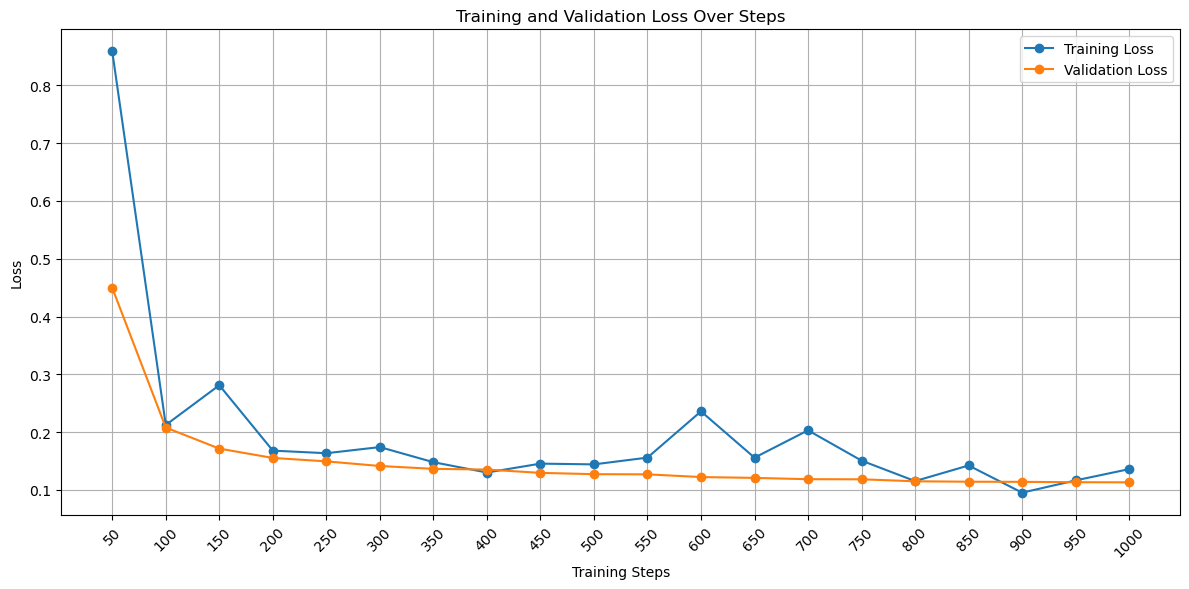

In [30]:
import matplotlib.pyplot as plt

# Provided training and validation loss values
steps = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
training_loss = [0.858500, 0.212400, 0.281200, 0.168100, 0.163600, 0.174200, 0.148100, 0.130200, 0.145600, 0.144300, 0.156000, 0.236000, 0.155900, 0.203200, 0.150800, 0.115400, 0.142400, 0.095400, 0.116600, 0.136100]
validation_loss = [0.449572, 0.207979, 0.171575, 0.155443, 0.149502, 0.141515, 0.136569, 0.135355, 0.129624, 0.127367, 0.127061, 0.122375, 0.120926, 0.118671, 0.118508, 0.115069, 0.114322, 0.114093, 0.113473, 0.113229]

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(steps, training_loss, label='Training Loss', marker='o')
plt.plot(steps, validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Steps')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.xticks(steps, rotation=45)  # Rotate the x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout for better fit
plt.show()

## Preparing an Independent Test Sample

After the initial training and evaluation, it's good practice to assess the model's performance on a new sample that was not seen during the training or validation phases. This ensures that the model's accuracy is not inflated by repeated exposure to the same test data.

In the following cell, I'll identify the test data that has already been used and exclude it from the full test set. Then, I will draw a new random sample from the remaining unused data and preprocess it in the same way as the training data. This independent test sample will provide a fair assessment of the model's true performance.


In [39]:
# Get indices of the test set rows that were used in the training/validation process
used_test_indices = test_data_random_subset.index.union(test_data_google_queries.index)

# Exclude these indices from the full test set to consider only the rows that were not used before
unused_test_data = full_test_data.drop(index=used_test_indices)

# Take a new random sample of 1500 from the unused test data
new_test_sample = unused_test_data.sample(n=1500, random_state=43)

# Preprocess the new test sample
tokenized_new_test_sample = new_test_sample.apply(preprocess_data, axis=1)

# Extract input_ids and attention_masks as separate lists
input_ids = tokenized_new_test_sample.apply(lambda x: x['input_ids'])
attention_masks = tokenized_new_test_sample.apply(lambda x: x['attention_mask'])

input_ids = input_ids.tolist()
attention_masks = attention_masks.tolist()

## Model Evaluation on Independent Test Sample

Now that we have prepared an independent test sample, the next step is to evaluate the model's performance on this new data. This cell performs the following actions:

- Import the PyTorch library, which is required for model operations.
- Set the device to CPU to ensure compatibility with the laptop used for this project.
- Place the model in evaluation mode to disable certain operations like dropout, which are only used during training.
- Generate predictions from the model using the new test sample data.
- Decode the generated sequences into a readable format.
- Calculate the accuracy of the predictions by comparing them to the actual SQL queries.

The calculated accuracy will give us an insight into how well the model can generalize to unseen data.

In [20]:
# First, import the torch library
import torch

# Set the device to CPU
device = torch.device("cpu")

# Put the model in evaluation mode
model.eval()
model.to(device)

# Move the tensors to the CPU
input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)

# Generate predictions
with torch.no_grad():
    # Use model.generate() to get the generated sequences
    generated_sequences = model.generate(input_ids=input_ids, attention_mask=attention_masks)

# Convert generated sequences to readable text
decoded_predictions = [tokenizer.decode(g, skip_special_tokens=True) for g in generated_sequences]

# Extract the list of correct SQL queries from the new test sample
actual_queries = new_test_sample['sql'].tolist()

# Function to calculate accuracy
def calculate_accuracy(predictions, actuals):
    correct = sum([1 for pred, act in zip(predictions, actuals) if pred.strip() == act.strip()])
    total = len(predictions)
    return correct / total

# Calculate accuracy
accuracy = calculate_accuracy(decoded_predictions, actual_queries)
print(f"Accuracy: {accuracy:.2f}")

C:\Users\hchenoy\AppData\Local\anaconda3\Lib\site-packages\transformers\generation\utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Accuracy: 0.14


## Model Prediction Analysis

In the following code cell, we will construct a DataFrame to compare the model's predicted SQL queries against the actual SQL queries from the test set. This will allow us to not only see where our model is performing well, but also to categorize and count the types of errors it is making, which is a critical step for further improving our model's accuracy.


In [23]:
import pandas as pd

# Create a DataFrame to compare the actual and predicted SQL queries
comparison_df = pd.DataFrame({
    'Actual': actual_queries,
    'Predicted': decoded_predictions,
    'Is_Correct': [act == pred for act, pred in zip(actual_queries, decoded_predictions)]
})

# Function to categorize errors
def categorize_error(actual, predicted):
    # Implement your error categorization logic here
    # For example:
    if actual == predicted:
        return 'Correct'
    if 'SELECT' in predicted and 'SELECT' not in actual:
        return 'Unwanted SELECT'
    # Add more conditions as needed
    return 'Other'

# Apply the function to categorize errors
comparison_df['Error_Type'] = comparison_df.apply(lambda x: categorize_error(x['Actual'], x['Predicted']), axis=1)

# Summarize the types of errors made by the model
error_summary = comparison_df['Error_Type'].value_counts()

## Model Error Analysis

The bar chart below visualizes the distribution of error types made by the model. The 'Other' category encapsulates all the incorrect predictions, while the 'Correct' category shows the number of predictions that matched the actual SQL queries exactly. This visualization is crucial for identifying how often the model was accurate and the predominant types of errors, informing potential areas of improvement


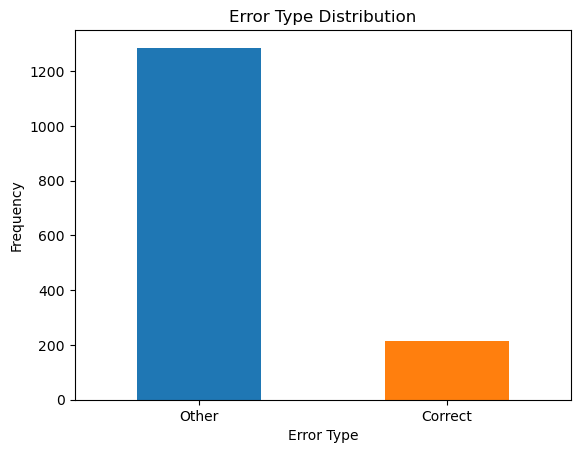

In [27]:
# Adjusting the code to use the typical orange and blue colors for the bar chart
colors = ['#1f77b4', '#ff7f0e']  # Blue for 'Other', Orange for 'Correct'
error_summary.plot(kind='bar', color=colors, title='Error Type Distribution')
plt.xlabel('Error Type')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep the labels on the x-axis readable
plt.show()


## Word Cloud of Correct SQL Queries

The word cloud depicted below illustrates the most frequent terms found in the SQL queries that the model predicted correctly. The size of each term in the visualization is proportional to its frequency. This not only offers a visual representation of the model's successes but also highlights the most common elements in correct SQL queries, potentially offering insights into patterns the model is learning effectively.


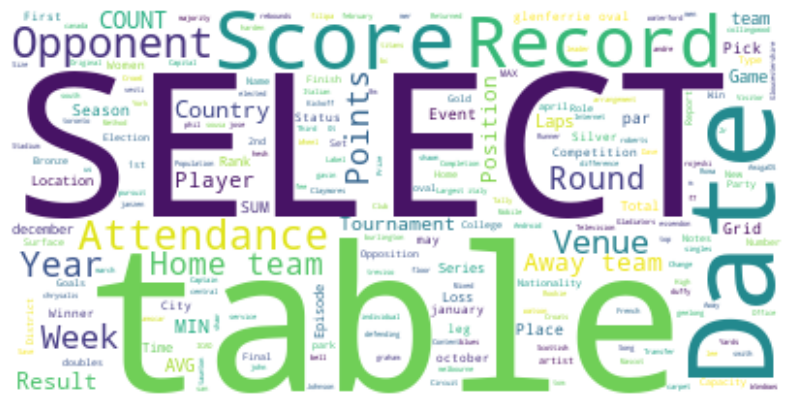

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter to get only correct predictions
correct_queries = comparison_df[comparison_df['Predicted'] == comparison_df['Actual']]['Actual']

# Combine all correct SQL queries into a single string
text = ' '.join(correct_queries)  # Adjust this if the column name is different

# Generate a word cloud image
wordcloud = WordCloud(background_color='white').generate(text)

# Display the generated image
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()

## Word Cloud of Questions Leading to Correct SQL Queries

This word cloud presents the most frequent terms from the natural language questions for which the model generated accurate SQL queries. Similar to the previous word cloud of SQL queries, the prominence of each term indicates its frequency. This visualization can help us understand which terms or phrases the model handles well and may point out commonalities in the questions that lead to successful SQL translations.


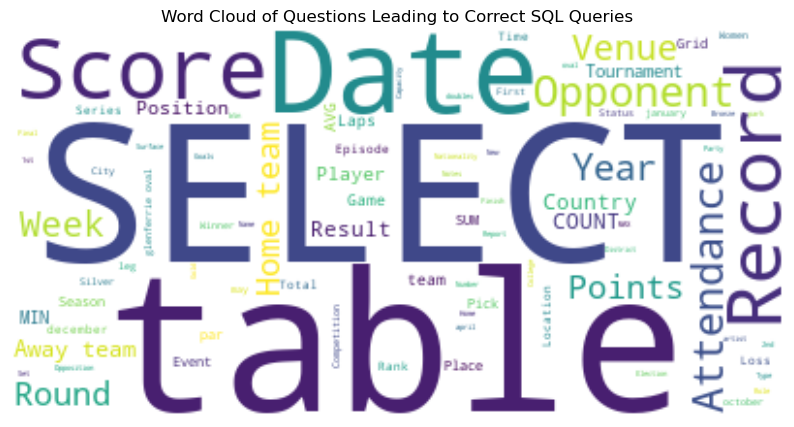

In [41]:
# Filter the dataframe to get questions that led to correct predictions
correct_questions = comparison_df[comparison_df['Is_Correct']]['Actual'].tolist()

# Combine all questions into a single string
questions_text = ' '.join(correct_questions)

# Generate and display the word cloud image
wordcloud = WordCloud(background_color='white', max_words=200, contour_width=3, contour_color='steelblue').generate(questions_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.title('Word Cloud of Questions Leading to Correct SQL Queries')
plt.show()


## Conclusion

In this exploration, I trained a machine learning model to translate natural language questions into SQL queries, a task of great value to non-technical users such as marketers. Despite the initial focus on Google search queries, the implications extend far beyond, showcasing the model's utility for various types of data querying. With a 14% accuracy on a subset of the full dataset and with limited computational resources, the project reveals the potential for significant improvements and broader applications.

The word clouds of correct SQL queries and their corresponding questions provide an interesting visual representation of where the model performs well. This project serves as a proof of concept that with more computational power and a larger dataset, it's possible to further enhance the accuracy and extend the model's applicability to a wide range of industries.

As we look to the future, scaling up the dataset, leveraging more powerful hardware, and refining the model could lead to a versatile tool that democratizes data analysis, empowering users to extract meaningful insights without prior SQL knowledge.